In [8]:
import csv
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from data import BodyPart 
import tensorflow as tf
from sklearn.metrics import confusion_matrix
#import tensorflowjs as tfjs




tfjs_model_dir = 'model'


# loading final csv file
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    df.drop(['filename'],axis=1, inplace=True)
    classes = df.pop('class_name').unique()
    y = df.pop('class_no')
    
    
    X = df.astype('float64')
    y = keras.utils.to_categorical(y)
    
    return X, y, classes


def get_center_point(landmarks, left_bodypart, right_bodypart):
    """Calculates the center point of the two given landmarks."""
    left = tf.gather(landmarks, left_bodypart.value, axis=1)
    right = tf.gather(landmarks, right_bodypart.value, axis=1)
    center = left * 0.5 + right * 0.5
    return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
    """Calculates pose size. It is the maximum of two values:    """
    # Hips center
    hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    # Shoulders center
    shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

    # Torso size as the minimum body size
    torso_size = tf.linalg.norm(shoulders_center - hips_center)
    # Pose center
    pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
    pose_center_new = tf.expand_dims(pose_center_new, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to
    # perform substraction
    pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

    # Dist to pose center
    d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
    # Max dist to pose center
    max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

    # Normalize scale
    pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)
    return pose_size



def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
    pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

    pose_center = tf.expand_dims(pose_center, axis=1)
    # Broadcast the pose center to the same size as the landmark vector to perform
    # substraction
    pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
    landmarks = landmarks - pose_center

    # Scale the landmarks to a constant pose size
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks


def landmarks_to_embedding(landmarks_and_scores):
    """Converts the input landmarks into a pose embedding."""
    # Reshape the flat input into a matrix with shape=(17, 3)
    reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

    # Normalize landmarks 2D
    landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])
    # Flatten the normalized landmark coordinates into a vector
    embedding = keras.layers.Flatten()(landmarks)
    return embedding


def preprocess_data(X_train):
    processed_X_train = []
    for i in range(X_train.shape[0]):
        embedding = landmarks_to_embedding(tf.reshape(tf.convert_to_tensor(X_train.iloc[i]), (1, 51)))
        processed_X_train.append(tf.reshape(embedding, (34)))
    return tf.convert_to_tensor(processed_X_train)


X, y, class_names = load_csv('train_data.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
X_test, y_test, _ = load_csv('test_data.csv')


processed_X_train = preprocess_data(X_train)
processed_X_val =  preprocess_data(X_val)
processed_X_test = preprocess_data(X_test)

inputs = tf.keras.Input(shape=(34))
layer = keras.layers.Dense(128, activation=tf.nn.relu6)(inputs)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
print('--------------TRAINING----------------')
history = model.fit(processed_X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(processed_X_val, y_val),
                    callbacks=[checkpoint, earlystopping])


print('-----------------EVAUATION----------------')
loss, accuracy = model.evaluate(processed_X_test, y_test)
# print('LOSS: ', loss)
# print("ACCURACY: ", accuracy)


# tfjs.converters.save_keras_model(model, tfjs_model_dir)
# print('tfjs model saved at ',tfjs_model_dir)
# confusion_matrix(y_train,y_val)


--------------TRAINING----------------
Epoch 1/200
60/81 [=====================>........] - ETA: 0s - loss: 1.7596 - accuracy: 0.3688
Epoch 1: val_accuracy improved from -inf to 0.50220, saving model to weights.best.hdf5
81/81 [==============================] - 2s 10ms/step - loss: 1.6684 - accuracy: 0.4070 - val_loss: 1.2697 - val_accuracy: 0.5022


c:\Users\Hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
70/81 [========================>.....] - ETA: 0s - loss: 1.1326 - accuracy: 0.6018
Epoch 2: val_accuracy improved from 0.50220 to 0.60352, saving model to weights.best.hdf5
81/81 [==============================] - 0s 5ms/step - loss: 1.1186 - accuracy: 0.6062 - val_loss: 0.8680 - val_accuracy: 0.6035
Epoch 3/200
69/81 [========================>.....] - ETA: 0s - loss: 0.9068 - accuracy: 0.6703
Epoch 3: val_accuracy improved from 0.60352 to 0.79295, saving model to weights.best.hdf5
81/81 [==============================] - 0s 5ms/step - loss: 0.8899 - accuracy: 0.6747 - val_loss: 0.6769 - val_accuracy: 0.7930
Epoch 4/200
76/81 [===========================>..] - ETA: 0s - loss: 0.7325 - accuracy: 0.7294
Epoch 4: val_accuracy improved from 0.79295 to 0.85903, saving model to weights.best.hdf5
81/81 [==============================] - 0s 6ms/step - loss: 0.7217 - accuracy: 0.7362 - val_loss: 0.5300 - val_accuracy: 0.8590
Epoch 5/200
81/81 [==============================] - ETA: 

In [9]:
print('LOSS: ', loss)
print("ACCURACY: ", accuracy)

LOSS:  0.025736985728144646
ACCURACY:  0.9920182228088379


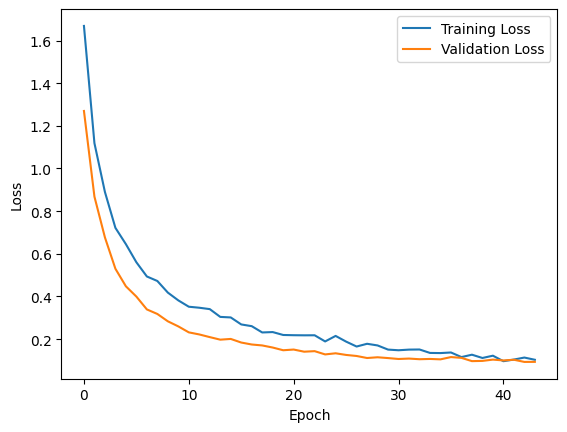

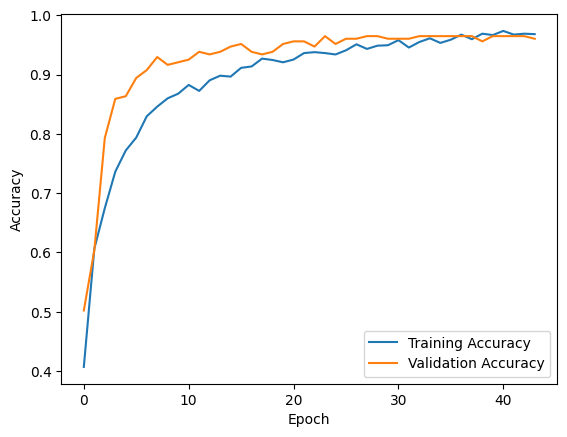

28/28 [==============================] - 0s 3ms/step
Confusion Matrix:
[[168   0   0   0   0   0   0   0]
 [  0 194   0   0   0   0   0   0]
 [  0   0 169   0   0   0   0   0]
 [  0   0   0   2   0   0   0   0]
 [  0   0   0   0   8   0   0   0]
 [  0   0   0   0   0  10   0   0]
 [  0   0   0   0   0   0 187   0]
 [  3   1   0   0   0   3   0 132]]
Classification Report:
                precision    recall  f1-score   support

         chair       0.98      1.00      0.99       168
         cobra       0.99      1.00      1.00       194
           dog       1.00      1.00      1.00       169
       no_pose       1.00      1.00      1.00         2
shoudler_stand       1.00      1.00      1.00         8
      traingle       0.77      1.00      0.87        10
          tree       1.00      1.00      1.00       187
       warrior       1.00      0.95      0.97       139

      accuracy                           0.99       877
     macro avg       0.97      0.99      0.98       877
  weigh

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Plot training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Generate predictions on the test set
y_pred = model.predict(processed_X_test)

# Convert one-hot encoded predictions to class labels
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report
class_report = classification_report(y_test_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(class_report)



In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate



# Training and Validation Loss Table
loss_table_data = {'Epoch': list(range(1, len(history.history['loss']) + 1)),
                   'Training Loss': history.history['loss'],
                   'Validation Loss': history.history['val_loss']}
loss_table = tabulate(loss_table_data, headers='keys', tablefmt='pretty')

print("Training and Validation Loss:")
print(loss_table)

# Training and Validation Accuracy Table
accuracy_table_data = {'Epoch': list(range(1, len(history.history['accuracy']) + 1)),
                       'Training Accuracy': history.history['accuracy'],
                       'Validation Accuracy': history.history['val_accuracy']}
accuracy_table = tabulate(accuracy_table_data, headers='keys', tablefmt='pretty')

print("\nTraining and Validation Accuracy:")
print(accuracy_table)

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate



# Convert Classification Report to a Dictionary
class_report_dict = classification_report(y_test_classes, y_pred_classes, target_names=class_names, output_dict=True)

# Confusion Matrix Table
conf_matrix_table = tabulate(conf_matrix, headers=class_names, tablefmt='pretty')

print("\nConfusion Matrix:")
print(conf_matrix_table)

# Classification Report Table
class_report_table = tabulate(class_report_dict.items(), tablefmt='pretty')

print("\nClassification Report:")
print(class_report_table)



Training and Validation Loss:
+-------+---------------------+---------------------+
| Epoch |    Training Loss    |   Validation Loss   |
+-------+---------------------+---------------------+
|   1   | 1.6683520078659058  | 1.2696563005447388  |
|   2   | 1.1186412572860718  | 0.8680088520050049  |
|   3   | 0.8899255394935608  | 0.6769267320632935  |
|   4   | 0.7217175960540771  | 0.5300037264823914  |
|   5   | 0.6452628374099731  | 0.4476625323295593  |
|   6   | 0.5603677034378052  | 0.39948099851608276 |
|   7   | 0.49378296732902527 | 0.3393295705318451  |
|   8   | 0.4725714325904846  | 0.3179939091205597  |
|   9   | 0.4181707501411438  | 0.28358837962150574 |
|  10   | 0.3816168010234833  | 0.2596711814403534  |
|  11   | 0.35194289684295654 | 0.23172982037067413 |
|  12   | 0.34720224142074585 |  0.221975639462471  |
|  13   |   0.3407002389431   | 0.20944981276988983 |
|  14   | 0.3042230010032654  | 0.19750389456748962 |
|  15   | 0.3017045557498932  | 0.2009396106004715  

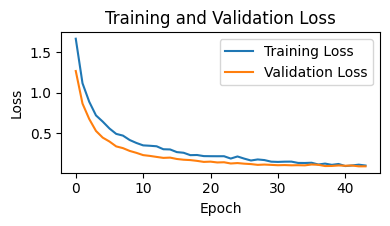

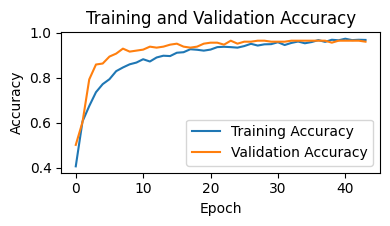

28/28 [==============================] - 0s 4ms/step

Classification Report:
+----------------+------------------------------------------------------------------------------------------------------------------+
|     chair      |        {'precision': 0.9824561403508771, 'recall': 1.0, 'f1-score': 0.9911504424778761, 'support': 168.0}        |
|     cobra      |        {'precision': 0.9948717948717949, 'recall': 1.0, 'f1-score': 0.9974293059125964, 'support': 194.0}        |
|      dog       |                       {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 169.0}                       |
|    no_pose     |                        {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0}                        |
| shoudler_stand |                        {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 8.0}                        |
|    traingle    |        {'precision': 0.7692307692307693, 'recall': 1.0, 'f1-score': 0.8695652173913044, 'support': 1

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate



# Set the size for 6x6 cm figures with increased width for the confusion matrix
figsize_6x6_cm_confusion = (4, 2.36)  # 6x6 cm in inches (1 inch = 2.54 cm)

# Plot training and validation loss over epochs
plt.figure(figsize=figsize_6x6_cm_confusion)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.tight_layout()
plt.savefig('training_loss.png', dpi=300)
plt.show()

# Plot training and validation accuracy over epochs
plt.figure(figsize=figsize_6x6_cm_confusion)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.tight_layout()
plt.savefig('training_accuracy.png', dpi=300)
plt.show()

# Generate predictions on the test set
y_pred = model.predict(processed_X_test)

# Convert one-hot encoded predictions to class labels
y_pred_classes = tf.argmax(y_pred, axis=1)
y_test_classes = tf.argmax(y_test, axis=1)



# Classification Report Table
class_report_table = classification_report(y_test_classes, y_pred_classes, target_names=class_names, output_dict=True)
class_report_table_str = tabulate(class_report_table.items(), tablefmt='pretty')

print("\nClassification Report:")
print(class_report_table_str)


In [14]:
# Assuming you have the confusion matrix stored in conf_matrix

TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]

# Specificity
specificity = TN / (TN + FP)

# Sensitivity
sensitivity = TP / (TP + FN)

print(f"Specificity: {specificity:.2f}")
print(f"Sensitivity: {sensitivity:.2f}")


Specificity: 1.00
Sensitivity: 1.00


In [15]:
from sklearn.metrics import confusion_matrix



TN = conf_matrix[0, 0]
FP = conf_matrix[0, 1]
FN = conf_matrix[1, 0]
TP = conf_matrix[1, 1]
print(TN,FP,FN,TP)


specificity = TN / (TN + FP)

selectivity = TP / (TP + FN)
print(specificity,selectivity)

# print(f"Specificity: {specificity:.2f}")
# print(f"Selectivity: {selectivity:.2f}")


168 0 0 194
1.0 1.0


In [10]:
confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


array([[168,   0,   0,   0,   0,   0,   0,   0],
       [  0, 194,   0,   0,   0,   0,   0,   0],
       [  0,   0, 169,   0,   0,   0,   0,   0],
       [  0,   0,   0,   2,   0,   0,   0,   0],
       [  0,   0,   0,   0,   8,   0,   0,   0],
       [  0,   0,   0,   0,   0,  10,   0,   0],
       [  0,   0,   0,   0,   0,   0, 187,   0],
       [  3,   0,   0,   0,   0,   0,   0, 136]], dtype=int64)